## Gaussian Processes regression: basic introductory example
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import numpy as np
import matplotlib.pyplot as plt

from eval_model import subplot_difficulty_matrix
from model_config import checkpoint_folder, players, all_players, model, abilities
checkpoint_folder = 'models/04_18/PPO_00_05'
players = ["500000", "7000000", "5800000"]
players = [f"{checkpoint_folder}/_{p}_steps" for p in players]

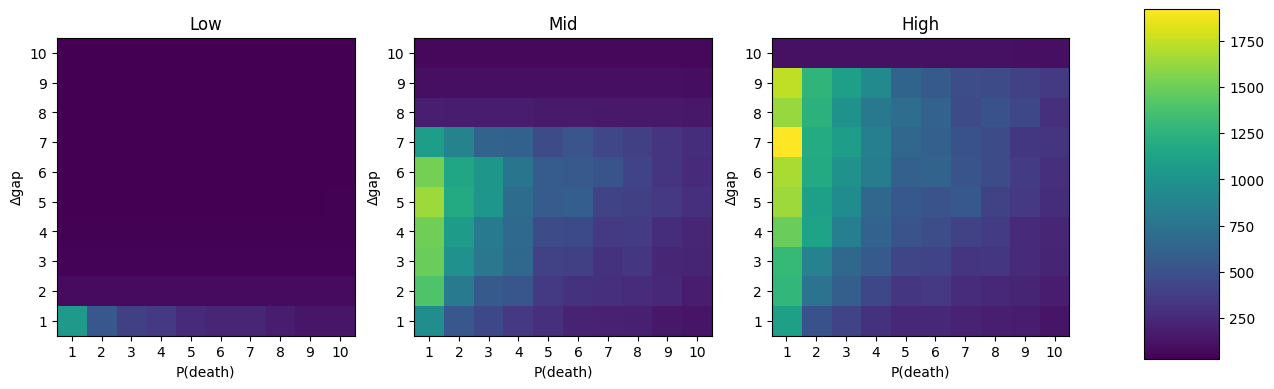

In [7]:
subplot_difficulty_matrix(players, share_cbar=True)

## Without noise

Pick a line from above to apply an example gaussian process regression like the above example.
Lets choose Low line 2

In [8]:
data = np.load(f"{players[-1]}_means.npy")
row = 6  # d=7

X_train = np.arange(1, 11).reshape(-1, 1)
y_train = data[row] # d=7

# Optimizing kernel hyperparameters on the training data
kernel = ConstantKernel(constant_value=1.14e+03**2,constant_value_bounds =(1e-1,1e10)) \
         * RBF(length_scale=1.59, length_scale_bounds=(1e-1, 1e10))
gaussian_process = GaussianProcessRegressor(kernel=kernel, 
                                            alpha=1e4, 
                                            n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

1.8e+03**2 * RBF(length_scale=5.72)

Following assumes no noise, which will be done later

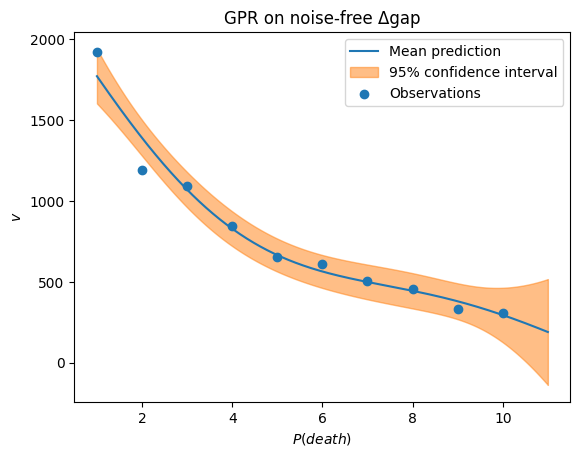

In [9]:
X = np.linspace(1, 11, 1_000).reshape(-1, 1)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)


plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    color="tab:orange",
    label=r"95% confidence interval",
)
plt.scatter(X_train, y_train, label="Observations", color="tab:blue")
plt.legend()
plt.xlabel("$P(death)$")
plt.ylabel("$v$")
plt.title("GPR on noise-free \u0394gap")
plt.show()

## Same WITH noise

In [10]:
data = np.load(f"{players[-1]}_means.npy")
row = 6  # d=7

X_train = np.arange(1, 11).reshape(-1, 1)
y_train = data[row] # d=7
std_mat = np.load(f"{players[-1]}_std.npy")
noise_std = std_mat[row]
noise_var = noise_std**2

# Optimizing kernel hyperparameters on the training data
kernel = ConstantKernel(constant_value=1.14e+03**2,constant_value_bounds =(1e-1,1e10)) \
         * RBF(length_scale=1.59, length_scale_bounds=(1e-1, 1e10))
gaussian_process = GaussianProcessRegressor(kernel=kernel, 
                                            alpha=noise_var, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

781**2 * RBF(length_scale=9.64)

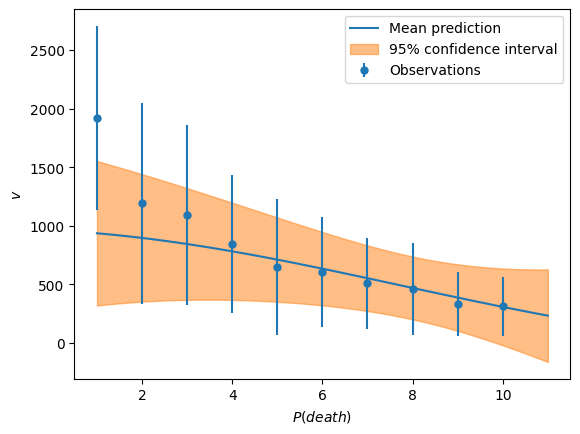

In [11]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
plt.errorbar(
    X_train,
    y_train,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$\u0394gap$")
plt.ylabel("$v$")
plt.xlabel("$P(death)$")
plt.show()

### Including $\Delta gap$

In [12]:
p = -1
data = np.load(f"{players[p]}_means.npy")
std_mat = np.load(f"{players[p]}_std.npy")
var = (std_mat**2).ravel()
X_train = np.array([(i, j) for j in range(1, 11) for i in range(1, 11)])
y_train = data.ravel()  # Unravels the 2D array into a 1D array

# Optimizing kernel hyperparameters on the training data
kernel = ConstantKernel(constant_value=1.14e+03**2,constant_value_bounds =(1e-1,1e10)) \
         * RBF(length_scale=1.59, length_scale_bounds=(1e-1, 1e10))
gaussian_process = GaussianProcessRegressor(kernel=kernel, 
                                            alpha=var, 
                                            n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

516**2 * RBF(length_scale=5.38)

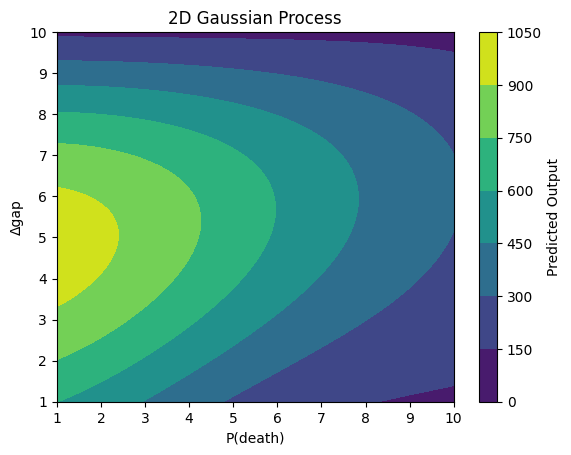

In [13]:
# Define grid points for plotting
D = np.linspace(1, 10, 100)
X, Y = np.meshgrid(D, D)
XY = np.column_stack([X.ravel(), Y.ravel()])

# Predict mean and standard deviation of predictions
y_pred, y_std = gaussian_process.predict(XY, return_std=True)
Z = y_pred.reshape(X.shape)
Z_std = y_std.reshape(X.shape)

# Plot the contour plot of the mean predictions
plt.contourf(X, Y, Z)
plt.colorbar(label='Predicted Output')

plt.xlabel("P(death)")
plt.ylabel("\u0394gap")
plt.title('2D Gaussian Process')
plt.show()

# Difficulty curves
$$
\lambda : \mathbb{R}^+ \mapsto \mathbb{R}^2 \\
d \in [1, 10] \mapsto \begin{bmatrix} P(death) \\ \Delta gap\end{bmatrix} \in [1, 10]^2
$$
We'll be playing with 
$$
\lambda_1(d) = \begin{bmatrix} d \\ 5 \end{bmatrix},\quad
\lambda_2(d) = \begin{bmatrix} 5 \\ d \end{bmatrix}
$$
Where the first travels along the x-axis and the second along the y-axis.

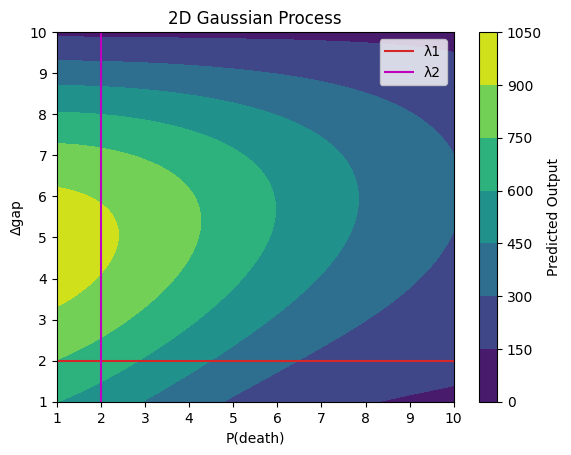

In [16]:
plt.contourf(X, Y, Z)
plt.colorbar(label='Predicted Output')
constant = 2
c1, c2 = 'tab:red', 'm'
plt.axhline(constant, color=c1, label='\u03BB1')
plt.axvline(constant, color=c2, label='\u03BB2')

plt.xlabel("P(death)")
plt.ylabel("\u0394gap")
plt.legend()
plt.title('2D Gaussian Process')
plt.show()

In [17]:
lambda_1 = lambda arr: np.column_stack((arr, np.full_like(arr, constant)))
lambda_2 = lambda arr: np.column_stack((np.full_like(arr, constant), arr))

line_1 = lambda_1(D)
line_2 = lambda_2(D)

y_pred_1 = gaussian_process.predict(line_1)
y_pred_2 = gaussian_process.predict(line_2)

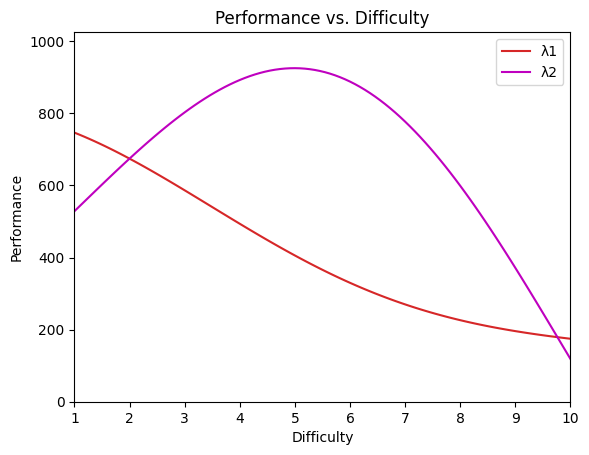

In [ ]:
# Plot performance vs. d
plt.plot(D, y_pred_1, label='\u03BB1', color=c1)
plt.plot(D, y_pred_2, label='\u03BB2', color=c2)
plt.xlabel('Difficulty')
plt.ylabel('Performance')
plt.xlim(1, 10)
# set y-axsis from 0 to max of y_pred_1 and y_pred_2
plt.ylim(0, max(max(y_pred_1), max(y_pred_2)) + 100)
plt.legend()
plt.title('Performance vs. Difficulty')
plt.show()

In [18]:
y_pred_1.shape

(100,)

## All players on lambda1

In [ ]:
from gaussian_process_regression import load_gaussian_process
gps = np.array(load_gaussian_process("gps.pkl"))

In [ ]:
D = np.linspace(1, 10, 100)

def plot_difficulty_curves(arr, diff_curve: callable):
    for gp in arr:
        plt.plot(D, gp.predict(diff_curve(D)), color='tab:red', alpha=0.2)
    plt.xlim(1, 10)
    plt.ylim(0, 850)
    plt.xlabel('Difficulty')
    plt.ylabel('Performance')
    plt.title('Performance vs. Difficulty')
    plt.show()


There is an obvious gap. What are the bottom?

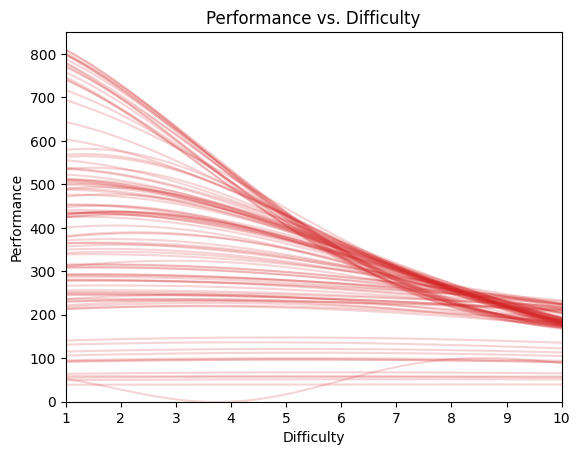

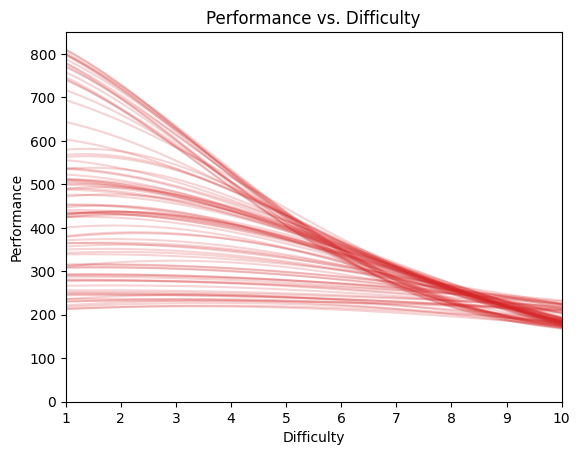

[ 2 46 57 68 35 13 24 90 79  1  5  3  4]


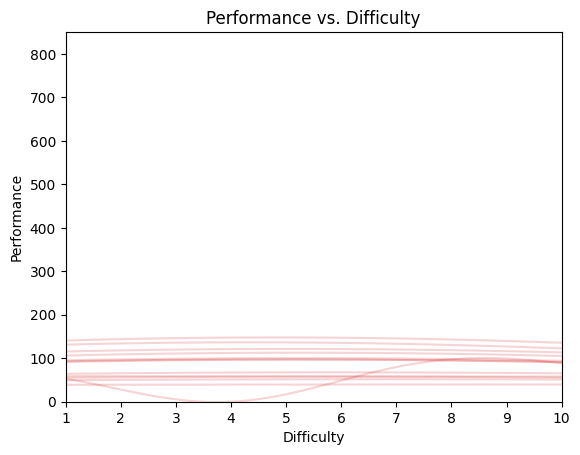

In [ ]:
plot_difficulty_curves(gps, lambda_1)

performances = [np.load(f"{p}_means.npy").mean() for p in all_players]
sort_index = np.argsort(performances)

plot_difficulty_curves(gps[sort_index[13:]], lambda_1)
print([sort_index[:13]][0])
plot_difficulty_curves(gps[sort_index[:13]], lambda_1)

### All on lambda_2

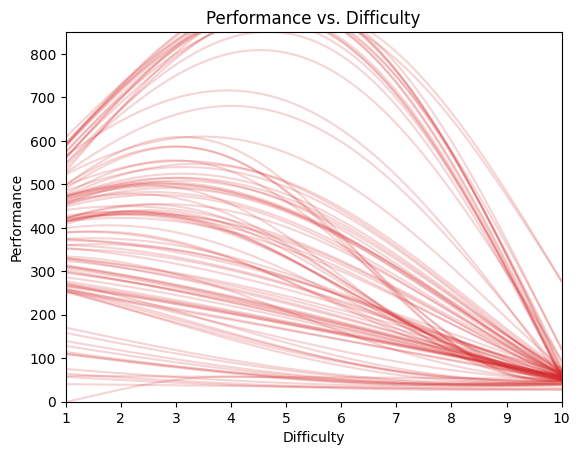

In [ ]:
plot_difficulty_curves(gps, lambda_2)

# Difficulty function

### 4th degree regression 
`theta` represents the coefficients of the polynomial, indexed by power of polynomial

In [ ]:
from sklearn.metrics import r2_score
x = np.linspace(1, 10, 100)
X = np.column_stack([x**i for i in range(5)])  # 4th degree polynomial
theta_ = np.linalg.inv(X.T @ X) @ X.T

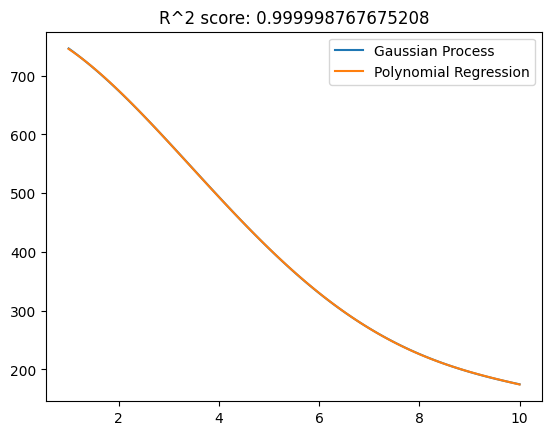

In [ ]:
y = gaussian_process.predict(lambda_1(x))

# Step 3: Solve the normal equation to find the optimal parameters
theta = theta_ @ y

# Step 4: Predict y-values for new x-values
# theta[0] -= 100
predicted_y = X @ theta  # Predicted y-values

plt.plot(x, y, label='Gaussian Process')
plt.plot(x, predicted_y, label='Polynomial Regression')
plt.title(f'R^2 score: {r2_score(y, predicted_y)}')
plt.legend()

In [ ]:
def find_x(theta, y=0, bounds=[0, 10]):
    _theta = [theta[0] - y, *theta[1:]]
    roots = np.roots(np.flip(_theta))  # Reverse the order of the coefficients
    real_roots = roots[np.isreal(roots)].real
    within_bounds = real_roots[(bounds[0] < real_roots) & (real_roots < bounds[1])]
    return within_bounds

target = 400
solution = find_x(theta, target)[0]
# array([-16.35625301,   5.19004967]

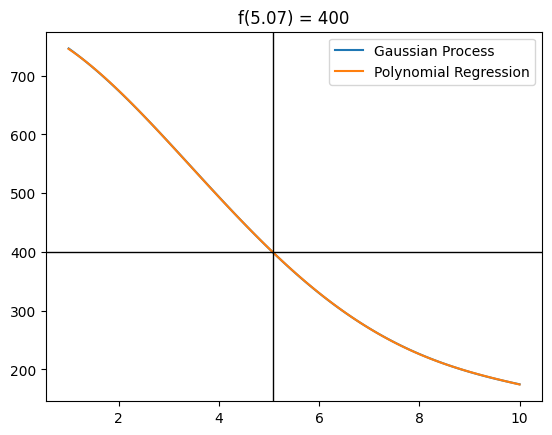

In [ ]:
plt.plot(x, y, label='Gaussian Process')
plt.plot(x, predicted_y, label='Polynomial Regression')
# plot horizontal line at y=0
plt.axhline(target, color='black', linewidth=1)
plt.axvline(solution, color='black', linewidth=1)
# show r^2 score
plt.title(f"f({solution:.2f}) = {target}")

plt.legend()
plt.show()

#### Is it fair to use polynomial regression?

In [ ]:
## Coefficient of determination over all players
r2s = []
for gp in gps[sort_index[13:]]:
    # Step 1: Generate sample data
    y = gp.predict(lambda_1(D))

    # Step 3: Solve the normal equation to find the optimal parameters
    theta = theta_ @ y

    # Step 4: Predict y-values for new x-values
    predicted_y = X @ theta  # Predicted y-values

    r2s.append(r2_score(y, predicted_y))
r2s = np.array(r2s)
r2s.min(), r2s.mean()

(0.9999709533705362, 0.9999959942173701)

### Scipy minimize

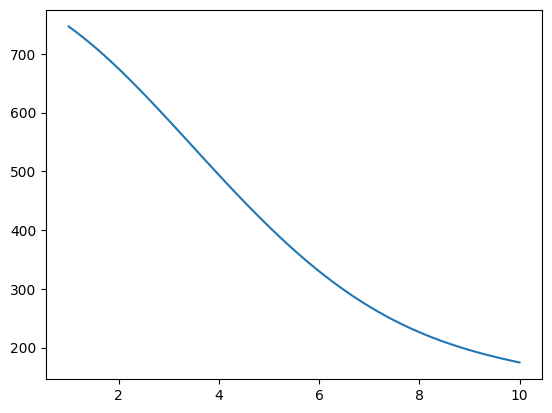

In [ ]:
y_pred = gaussian_process.predict(lambda_1(D))
plt.plot(D, y_pred, label='Gaussian Process')
plt.show()

In [ ]:
from scipy.optimize import minimize

# Define a function to minimize

def get_difficulty(performance):

    # Define the target output
    target_output = performance  # Example target output

    def objective_func(x):
        d = lambda_2(x)
        y_pred = gaussian_process.predict(d)
        return (y_pred - target_output) ** 2

    x0 = 5
    result = minimize(objective_func, x0, 
                    method='Powell',
                    #   method='Nelder-Mead',
                    tol=1e-6,
                    bounds=[(0, 10)])
                    # options={'disp': True, 'ftol': 1})

    # Extract the optimal input values
    optimal_input = result.x[0] 
    optimal_output = gaussian_process.predict(lambda_2(optimal_input))[0]
    
    if abs(target_output - optimal_output) < 1:
        print(f"f({optimal_input:.2f}) = {optimal_output:.2f}")
    else:
        print(f"No solution found")

get_difficulty(400)


f(8.88) = 400.00
f(8.88) = 400.00
f(8.88) = 400.00
f(8.88) = 400.00
f(8.88) = 400.00
f(8.88) = 400.00
f(8.88) = 400.00
f(8.88) = 400.00
f(8.88) = 400.00
f(8.88) = 400.00


# Abilties
Defined as the mean performance of the difficulty matrix, i.e. average performance across all difficulties.

In [ ]:
from model_config import all_players

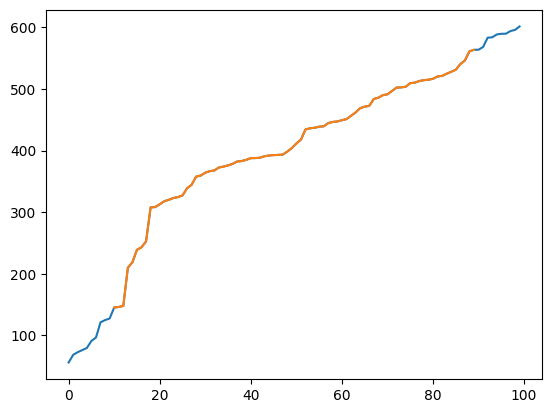

In [ ]:
ability_dict = {player : np.load(f"{player}_means.npy").mean() for player in all_players}
# rank players by ability in a numpy array with columns (player, ability)
ranked_players = np.array(sorted(ability_dict.items(), key=lambda x: x[1]))
# Extract the player names
player_names = ranked_players[:, 0]
# Extract the player abilities
abilities = ranked_players[:, 1].astype(float)

plt.plot(abilities)
plt.plot(range(10, 90), abilities[10:-10])


In [ ]:
ranked_players[:10]

array([['models/04_18/PPO_00_05/_100000_steps', '55.751000000000005'],
       ['models/04_18/PPO_00_05/_500000_steps', '68.21559999999998'],
       ['models/04_18/PPO_00_05/_600000_steps', '72.51639999999999'],
       ['models/04_18/PPO_00_05/_700000_steps', '75.88380000000001'],
       ['models/04_18/PPO_00_05/_400000_steps', '79.32199999999999'],
       ['models/04_18/PPO_00_05/_200000_steps', '90.77340000000004'],
       ['models/04_18/PPO_00_05/_300000_steps', '96.25399999999999'],
       ['models/04_18/PPO_00_05/_900000_steps', '120.97139999999999'],
       ['models/04_18/PPO_00_05/_800000_steps', '124.63520000000003'],
       ['models/04_18/PPO_00_05/_1000000_steps', '127.1968']],
      dtype='<U38')